### Steps:
1. Read and Visualise the data
2. Clean the data
3. Data preparation for modelling
4. Modeeling
5. Final analysis and reco

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import silhouette_score

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import chardet

# with open('Online+Retail.csv', 'rb') as file:
#     data = chardet.detect(file.read())
#     print(data)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [13]:
df = pd.read_csv('Online+Retail.csv', sep=',',encoding='ISO-8859-1', header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [14]:
df.shape

(541909, 8)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Handle Missing Value

In [20]:
round(df.isnull().sum() * 100/ len(df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [21]:
df = df.dropna()
df.shape

(406829, 8)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [24]:
df['amount'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


### Prepare data for Modelling

 - R: Recency: Number of Days since last purchase
 - F: Frequency: Number of transactions
 - M: Monetory: Total Amount Spent

### Monetory

In [23]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [31]:
# Sum will return a series with CustomerId as Index, but we want this as a dictionary so we can call reset_index() to do that
grouped_df = df.groupby('CustomerID')['amount'].sum().reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Frequency

In [34]:
frequency_df = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency_df.columns = ['CustomerID', 'frequency']
frequency_df.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [36]:
grouped_df = grouped_df.merge(frequency_df, how='inner', on='CustomerID')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Recency

In [39]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [42]:
max_date = df['InvoiceDate'].max()

In [45]:
df['diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [50]:
last_purchase = df.groupby('CustomerID')['diff'].min().reset_index()
last_purchase.columns = ['CustomerID', 'recency']
last_purchase.head()

,CustomerID,recency
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [51]:
last_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  4372 non-null   float64        
 1   recency     4372 non-null   timedelta64[ns]
dtypes: float64(1), timedelta64[ns](1)
memory usage: 68.4 KB


In [52]:
grouped_df = grouped_df.merge(last_purchase, how='inner', on='CustomerID')
grouped_df.head()

,CustomerID,amount,frequency,diff,recency
0,12346.0,0.00,2,325 days 02:33:00,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00,309 days 20:49:00


In [58]:
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [61]:
# Handle Outliers
grouped_df.describe([.25, .5, .75, .9, .95, .99])

,CustomerID,amount,frequency,recency
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,1898.459701,93.053294,91.047118
std,1722.390705,8219.345141,232.471608,100.765435
min,12346.000000,-4287.630000,1.000000,0.000000
25%,13812.750000,293.362500,17.000000,16.000000
50%,15300.500000,648.075000,42.000000,49.000000
75%,16778.250000,1611.725000,102.000000,142.000000
90%,17685.900000,3505.600000,212.000000,263.000000
95%,17984.450000,5625.004000,317.900000,312.000000
99%,18226.290000,17226.294900,671.870000,368.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe11925c310>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe11925c520>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1192993a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe11929b0a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe11929b340>],
 'means': []}

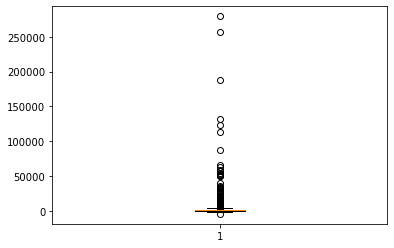

In [63]:
plt.boxplot(grouped_df.amount)

In [64]:
# There are two types of Outliers
# 1. Statistical Outlier: anything outside 1.5*IQR will be consider as outlier
# 2. Domain specific outlier: 

In [67]:
# Rescaling
from sklearn.preprocessing import StandardScaler

In [68]:
rfm_df = grouped_df[['amount', 'frequency', 'recency']]
scaler = StandardScaler()

In [75]:
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled

array([[-0.23100099, -0.3917197 ,  2.32202285],
       [ 0.29343167,  0.38265697, -0.89373323],
       [-0.01231622, -0.26695902, -0.1691956 ],
       ...,
       [-0.20951263, -0.34439668, -0.83418219],
       [ 0.02390005,  2.85205812, -0.87388289],
       [-0.00744423, -0.0991774 , -0.48680114]])

## Hopkins Statistics

In [76]:
# Hopkins statistics is used to identify the number of optimal clusters

In [77]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [78]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']

In [79]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9910828705939205

In [80]:
from sklearn.cluster import KMeans

In [81]:
?KMeans

In [82]:
model = KMeans(n_clusters=4, max_iter=50, random_state=42)
model.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4, random_state=42)

In [83]:
model.labels_

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

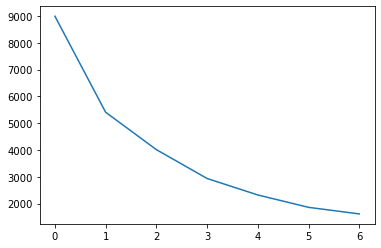

In [84]:
# elbow-curve/ Square Sum of Difference technique(SSD)

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)

### Silhouette Analysis

In [87]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    score = silhouette_score(rfm_df_scaled, cluster_labels)
    
    print(f"Silhoutte score for numer of cluster {num_clusters} is {score}")
    

Silhoutte score for numer of cluster 2 is 0.9293984525918874
Silhoutte score for numer of cluster 3 is 0.6003883114752382
Silhoutte score for numer of cluster 4 is 0.5974616027126741
Silhoutte score for numer of cluster 5 is 0.6148206579543399
Silhoutte score for numer of cluster 6 is 0.5807728645736332
Silhoutte score for numer of cluster 7 is 0.5254449565507899
Silhoutte score for numer of cluster 8 is 0.5096724058319645


In [88]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random', ndarray, callable}, default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` observations (rows) at random from data
 |      for 

In [89]:
# Create Kmeans with 3 clusters
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

kmeans.labels_

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [90]:
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

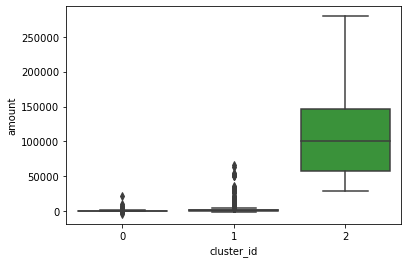

In [92]:
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

In [93]:
# The Variance in Cluster 2 is more than anytoher clusters, this is due to outliers present in the data.

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

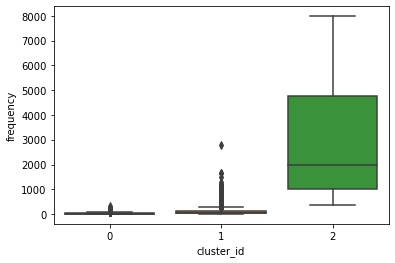

In [94]:
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

# The Variance in Cluster 2 is more than anytoher clusters, this is due to outliers present in the data.

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

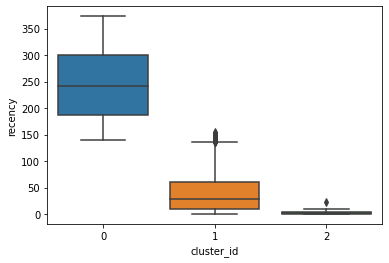

In [95]:
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

# The Variance in Cluster 2 is more than anytoher clusters, this is due to outliers present in the data.